In [1]:
import zipfile

import numpy as np
import tensorflow as tf

from helpers.prepare import Word2VecSkipGramTrainingDataBuilder, Word2VecCBOWTrainingDataBuilder
from helpers.dataset import TensorFlowDataset, import_zip_file
from models.word2vec import Word2Vec

# Load initial data

In [3]:
PATH = '../data/text8.zip'

In [4]:
corpus = import_zip_file(path=PATH, n_characters=50000000)

# Define some parameters

In [2]:
VOCABULARY_SIZE = 50000
BATCH_SIZE = 128
EMBEDDING_VECTOR_SIZE = 128
NEGATIVE_EXAMPLES_TO_SAMPLE_IN_SOFTMAX = 64
NUM_STEPS = 100000

# Skip-gram model

## Generate training data

In [ ]:
skip_gram_training_data = Word2VecSkipGramTrainingDataBuilder.build(corpus=corpus, vocabulary_size=VOCABULARY_SIZE)

In [5]:
VALIDATION_TOKENS = [
    'united', 'four', 'first', 'system', 'his', 'than', 'would', 'seven', 
    'after', 'eight', 'three', 'new', 'their', 'they', 'it', 'people',
]
VALIDATION_TOKEN_INDICES = [
    skip_gram_training_data.token_to_index_lookup[token] for token in VALIDATION_TOKENS
]
NUM_VALIDATION_NEAREST_NEIGHBORS = 8

In [6]:
training_dataset = TensorFlowDataset(
    data=np.array(skip_gram_training_data.X_train[0]),
    labels=np.array(skip_gram_training_data.y_train[0])
)

## Build graph

In [7]:
graph = tf.Graph()

with graph.as_default():

    # datasets
    dataset = TensorFlowDataset(
        data=tf.placeholder(dtype=tf.int32, shape=[BATCH_SIZE]),
        labels=tf.placeholder(dtype=tf.int32, shape=[BATCH_SIZE, 1])
    )
    validation_data = tf.constant(VALIDATION_TOKEN_INDICES, dtype=tf.int32)
    
    # model
    model = Word2Vec(
        dataset=dataset, 
        vocabulary_size=VOCABULARY_SIZE,
        embedding_vector_size=EMBEDDING_VECTOR_SIZE,
        negative_examples_to_sample_in_softmax=NEGATIVE_EXAMPLES_TO_SAMPLE_IN_SOFTMAX
    )
    
    # normalized embeddings
    normalized_embeddings = model.compute_normalized_embeddings()
    
    # lookup validation words
    validation_embeddings = tf.nn.embedding_lookup(params=normalized_embeddings, ids=validation_data)

    # compute similarities
    similarity = tf.matmul(validation_embeddings, tf.transpose(normalized_embeddings))

In [8]:
with tf.Session(graph=graph) as session:

    session.run(tf.initialize_all_variables())
    num_training_instances = len(training_dataset.data)
    average_loss = 0

    for step in range(NUM_STEPS):
        
        # define training batch
        training_batch_data, training_batch_labels = training_dataset.sample(BATCH_SIZE)
        training_batch_labels = training_batch_labels.reshape(-1, 1)

        # optimize
        feed_dict = {dataset.data: training_batch_data, dataset.labels: training_batch_labels}
        _, loss = session.run([model.optimize(), model.compute_loss()], feed_dict=feed_dict)
        average_loss += loss
        
        # evaluate loss
        if step % 5000 == 0 and step > 0:
            print('Average loss at step {}: {}'.format(step, average_loss / 5000))
            average_loss = 0
            
        # evaluate model on validation set
        if step % 10000 == 0 and step > 0:
            similarities = similarity.eval()
            for i, token_index in enumerate(VALIDATION_TOKEN_INDICES):
                word = skip_gram_training_data.index_to_token_lookup[token_index]
                nearest_neighbors = (-similarities[i, :]).argsort()[:NUM_VALIDATION_NEAREST_NEIGHBORS+1]
                log = 'Words nearest to \'{}\':'.format(word)
                
                for neighbor_index in nearest_neighbors:
                    neighbor_word = skip_gram_training_data.index_to_token_lookup.get(neighbor_index, 'not-in-vocabulary')
                    log = '{} {},'.format(log, neighbor_word)
                print(log)
    final_embeddings = normalized_embeddings.eval()

Average loss at step 5000: 1.5345047870755195
Average loss at step 10000: 1.2969500411868096
Words nearest to 'united': united, messina, shadowed, improve, scooby, fiercely, appropriating, americanism, entoprocta,
Words nearest to 'four': four, six, zero, one, nine, two, eight, five, lustrum,
Words nearest to 'first': first, intolerable, insisting, laine, henryk, votes, climb, stevens, noodle,
Words nearest to 'system': system, pherae, instructions, fanzines, sympathetic, modulus, goku, buteo, savannas,
Words nearest to 'his': his, hiroshima, prostrate, transgressions, czar, derrida, subtly, wavelet, anorexia,
Words nearest to 'than': than, congregationalism, wap, carbonate, repeating, carbons, lattices, gniezno, rien,
Words nearest to 'would': would, department, picirilli, plump, color, midfielder, headmaster, vodafone, excitation,
Words nearest to 'seven': seven, one, nine, eight, two, five, three, zero, nsync,
Words nearest to 'after': after, considering, plunging, isoleucine, sud, 

# Visualize

In [9]:
from collections import Counter

from matplotlib import pylab
from sklearn.manifold import TSNE

In [10]:
words_to_plot = Counter( skip_gram_training_data.training_data_as_tokens[0] ).most_common(400)
words_to_plot = [word_count[0] for word_count in words_to_plot]

indices_to_plot = [skip_gram_training_data.token_to_index_lookup[token] for token in words_to_plot]

In [11]:
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_dimensional_embeddings = tsne.fit_transform(final_embeddings[indices_to_plot])

In [12]:
def plot_two_dimensional_vectors(embeddings, words):

    pylab.figure(figsize=(15,15))

    for index, word in enumerate(words):
        x, y = embeddings[index, :]
        pylab.scatter(x, y)
        pylab.annotate(word, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
    pylab.show()

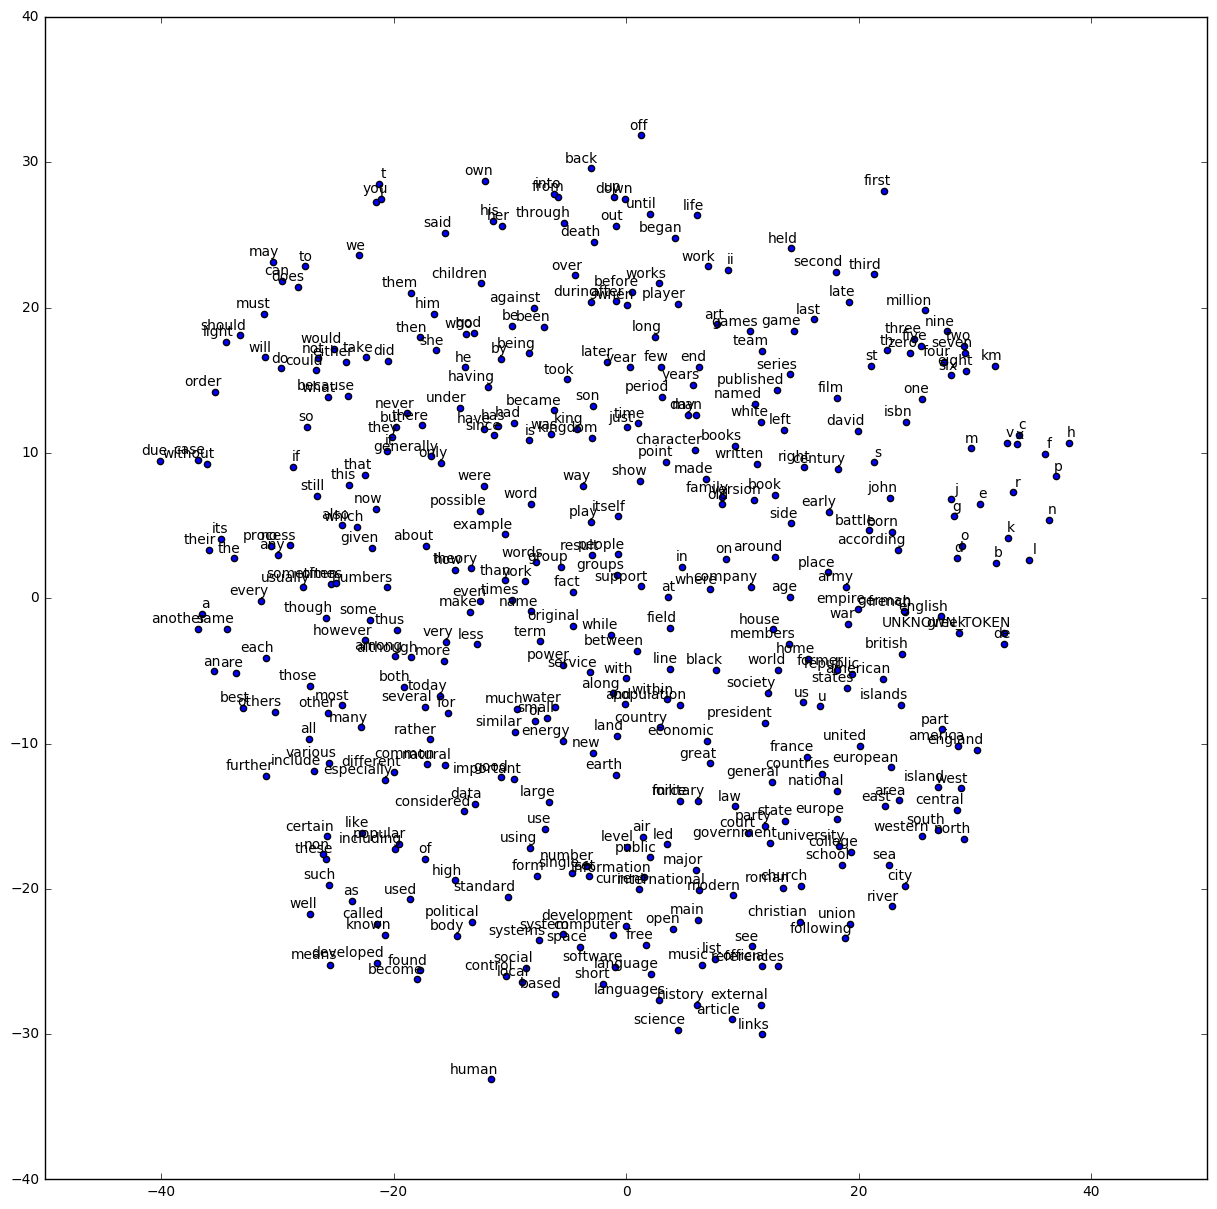

In [13]:
plot_two_dimensional_vectors(embeddings=two_dimensional_embeddings, words=words_to_plot)

# Continuous bag-of-words model

## Generate training data

In [108]:
cbow_training_data = Word2VecCBOWTrainingDataBuilder.build(corpus=corpus, vocabulary_size=VOCABULARY_SIZE)

In [16]:
VALIDATION_TOKENS = [
    'united', 'four', 'first', 'system', 'his', 'than', 'would', 'seven', 
    'after', 'eight', 'three', 'new', 'their', 'they', 'it', 'people',
]
VALIDATION_TOKEN_INDICES = [
    cbow_training_data.token_to_index_lookup[token] for token in VALIDATION_TOKENS
]
NUM_VALIDATION_NEAREST_NEIGHBORS = 8

In [17]:
training_dataset = TensorFlowDataset(
    data=np.array(cbow_training_data.X_train[0]),
    labels=np.array(cbow_training_data.y_train[0])
)

## Build graph

In [15]:
WORD_PADDING = cbow_training_data.WORD_PADDING

In [18]:
graph = tf.Graph()

with graph.as_default():

    # datasets
    dataset = TensorFlowDataset(
        data=tf.placeholder(dtype=tf.int32, shape=[BATCH_SIZE, 2*WORD_PADDING]),
        labels=tf.placeholder(dtype=tf.int32, shape=[BATCH_SIZE, 1])
    )
    validation_data = tf.constant(VALIDATION_TOKEN_INDICES, dtype=tf.int32)
    
    # model
    model = Word2Vec(
        dataset=dataset, 
        vocabulary_size=VOCABULARY_SIZE,
        embedding_vector_size=EMBEDDING_VECTOR_SIZE,
        negative_examples_to_sample_in_softmax=NEGATIVE_EXAMPLES_TO_SAMPLE_IN_SOFTMAX
    )
    
    # normalized embeddings
    normalized_embeddings = model.compute_normalized_embeddings()
    
    # lookup validation words
    validation_embeddings = tf.nn.embedding_lookup(params=normalized_embeddings, ids=validation_data)

    # compute similarities
    similarity = tf.matmul(validation_embeddings, tf.transpose(normalized_embeddings))

In [19]:
with tf.Session(graph=graph) as session:

    session.run(tf.initialize_all_variables())
    num_training_instances = len(training_dataset.data)
    average_loss = 0

    for step in range(NUM_STEPS):
        
        # define training batch
        training_batch_data, training_batch_labels = training_dataset.sample(BATCH_SIZE)
        training_batch_labels = training_batch_labels.reshape(-1, 1)

        # optimize
        feed_dict = {dataset.data: training_batch_data, dataset.labels: training_batch_labels}
        _, loss = session.run([model.optimize(), model.compute_loss()], feed_dict=feed_dict)
        average_loss += loss
        
        # evaluate loss
        if step % 5000 == 0 and step > 0:
            print('Average loss at step {}: {}'.format(step, average_loss / 5000))
            average_loss = 0
            
        # evaluate model on validation set
        if step % 10000 == 0 and step > 0:
            similarities = similarity.eval()
            for i, token_index in enumerate(VALIDATION_TOKEN_INDICES):
                word = cbow_training_data.index_to_token_lookup[token_index]
                nearest_neighbors = (-similarities[i, :]).argsort()[:NUM_VALIDATION_NEAREST_NEIGHBORS+1]
                log = 'Words nearest to \'{}\':'.format(word)
                
                for neighbor_index in nearest_neighbors:
                    neighbor_word = cbow_training_data.index_to_token_lookup.get(neighbor_index, 'not-in-vocabulary')
                    log = '{} {},'.format(log, neighbor_word)
                print(log)
    final_embeddings = normalized_embeddings.eval()

Average loss at step 5000: 1.5350100876808166
Average loss at step 10000: 1.257489564728737
Words nearest to 'united': united, spins, ur, tombaugh, unsteady, gnostic, rigorously, strive, cotswolds,
Words nearest to 'four': four, five, six, seven, two, three, zero, one, eight,
Words nearest to 'first': first, retired, darren, bst, buy, tokens, millions, mughals, lissodelphis,
Words nearest to 'system': system, archipelagoes, warhawk, caribs, ortiz, eagle, relent, which, fayette,
Words nearest to 'his': his, s, their, her, nunavut, psoe, nowell, spectroscopically, aspartate,
Words nearest to 'than': than, toxicity, nearly, advancing, deprotonation, chogm, classes, admissions, limbic,
Words nearest to 'would': would, to, can, peasant, thera, morris, aga, may, qwerty,
Words nearest to 'seven': seven, four, five, zero, three, eight, six, lading, anguish,
Words nearest to 'after': after, vci, hales, arbitrary, dares, move, soundtrackinfo, civilized, transcendentalism,
Words nearest to 'eight

# Visualize

In [20]:
words_to_plot = Counter( cbow_training_data.training_data_as_tokens[0] ).most_common(400)
words_to_plot = [word_count[0] for word_count in words_to_plot]

indices_to_plot = [cbow_training_data.token_to_index_lookup[token] for token in words_to_plot]

In [21]:
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_dimensional_embeddings = tsne.fit_transform(final_embeddings[indices_to_plot])

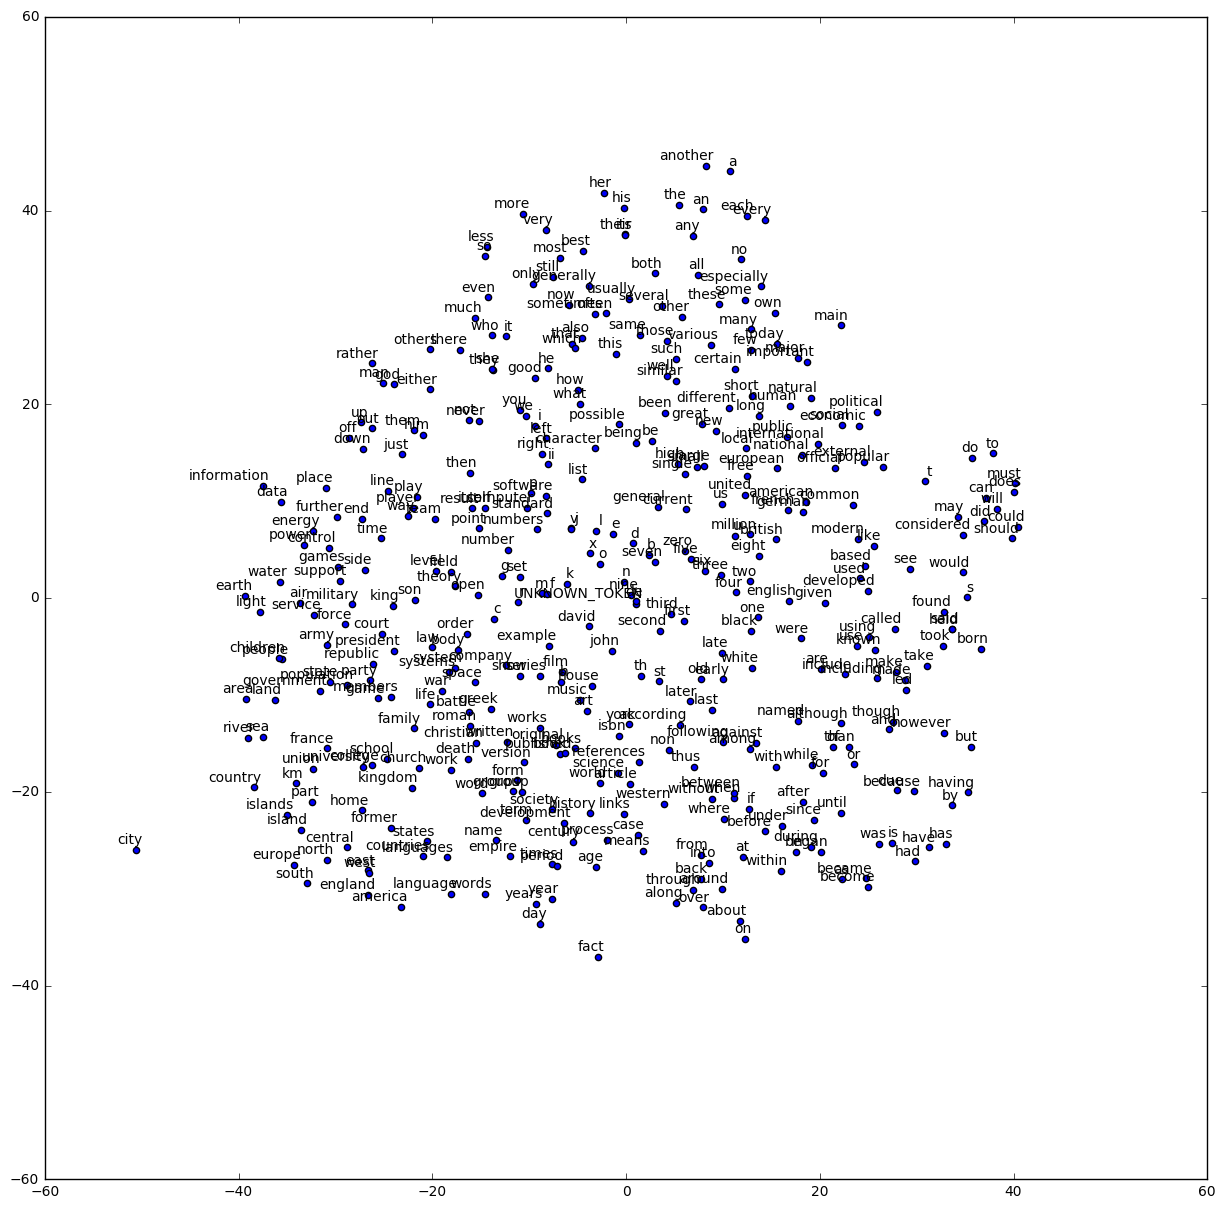

In [22]:
plot_two_dimensional_vectors(embeddings=two_dimensional_embeddings, words=words_to_plot)